### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
os.path.dirname(os.path.abspath('__file__'))
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import random

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
## Import_Local (현재 프로그램에서 미사용)
from Src_Dev_Common import DEV_Common_Data_Datetime as com_date
from Src_Dev_Common import DEV_KASI_Holiday as com_Holi
from Src_Dev_Common import DEV_Common_Data_Analysis as com_Analysis
from Src_Dev_Common import DEV_Common_Data_Preprocessing as com_Prep
from Src_Dev_Common import DEV_Common_Data_Visualization as com_Visual
from Src_Dev_Common import DEV_KMA_Weather_ASOS as com_KMA

### 01-01-02. Config (Directory, Params)

In [4]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [5]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-01-09 09:38:20.159156
2024 / 1 / 9
9 : 38


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [6]:
# Define data root directory
str_dir_kdhcHeat = "../data/data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + 'KDHC_NATIONAL_HEAT_hr.csv', index_col = 0)
print(df_kdhc_heat.columns)
df_kdhc_heat

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATSxPCA01_2019-2022_Scaled.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_HEAT_2019-2022.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT_19Region_hr.csv', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']
Index(['METER_DATE', 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM',
       'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG',
       'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU',
       'YANGSAN', 'GWANGJU_JEONNAM'],
      dtype='object')


,METER_DATE,PAJU,GOYANG,SAMSONG,JOONGANG,KANGNAM,PANGYO,BUNDANG,YONGIN,GWANGGYO,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,20,73.0000000000,8.0000000000,20.0000000000,61.3000000000,8.0000000000,55.1000000000,30.0000000000,14.0000000000,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
1,2019-10-01 02:00:00,15,65.0000000000,12.0000000000,18.0000000000,61.3000000000,4.0000000000,56.0000000000,25.0000000000,7.0000000000,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
2,2019-10-01 03:00:00,14,58.0000000000,12.0000000000,17.0000000000,56.3000000000,5.0000000000,51.0000000000,18.0000000000,11.0000000000,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
3,2019-10-01 04:00:00,14,56.0000000000,9.0000000000,15.0000000000,53.3000000000,6.0000000000,48.9000000000,17.0000000000,6.0000000000,38.0000000000,13.0000000000,18,0.5000000000,11,16.0000000000,6,13.0000000000,8,2
4,2019-10-01 05:00:00,14,48.0000000000,11.0000000000,14.0000000000,54.3000000000,6.0000000000,44.9000000000,23.0000000000,2.0000000000,42.0000000000,13.0000000000,15,0.5000000000,11,18.0000000000,6,13.0000000000,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,2022-09-30 20:00:00,41,81.0000000000,44.0000000000,45.0000000000,120.0000000000,37.0000000000,74.4000000000,87.0000000000,40.0000000000,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
326,2022-09-30 21:00:00,40,90.0000000000,46.0000000000,46.0000000000,112.0000000000,36.0000000000,78.4000000000,91.0000000000,25.0000000000,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
327,2022-09-30 22:00:00,37,95.0000000000,39.0000000000,44.0000000000,95.0000000000,24.0000000000,65.4000000000,81.0000000000,16.0000000000,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
328,2022-09-30 23:00:00,32,98.0000000000,35.0000000000,41.0000000000,89.0000000000,19.0000000000,51.4000000000,80.0000000000,16.0000000000,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6


PAJU
=============== Descriptive Statistic ===============
Min of tar : 1
Std of tar : 40.25238015258739
Median of tar : 33.0
Mean of tar : 48.77225945866755
Max of tar : 224
=============== Descriptive Statistic ===============
===============  IQR Range =============== 
===============  IQR Range =============== 
246.5
110.0
91.0
33.0
19.0
-117.5
===============  IQR Range =============== 
cnt_outlier = 0
===============  IQR Range =============== 
===============  IQR Range =============== 
246.5
110.0
91.0
33.0
19.0
-117.5
===============  IQR Range =============== 
cnt_outlier = 0
===============  IQR Range =============== 
246.5
110.0
91.0
33.0
19.0
-117.5
===============  IQR Range =============== 
cnt_outlier = 0
0
===============  IQR Range =============== 
246.5
110.0
91.0
33.0
19.0
-117.5
===============  IQR Range =============== 
cnt_outlier = 0
0
===============  IQR Range =============== 
246.5
110.0
91.0
33.0
19.0
-117.5
===============  IQR Range =============== 
cnt_o

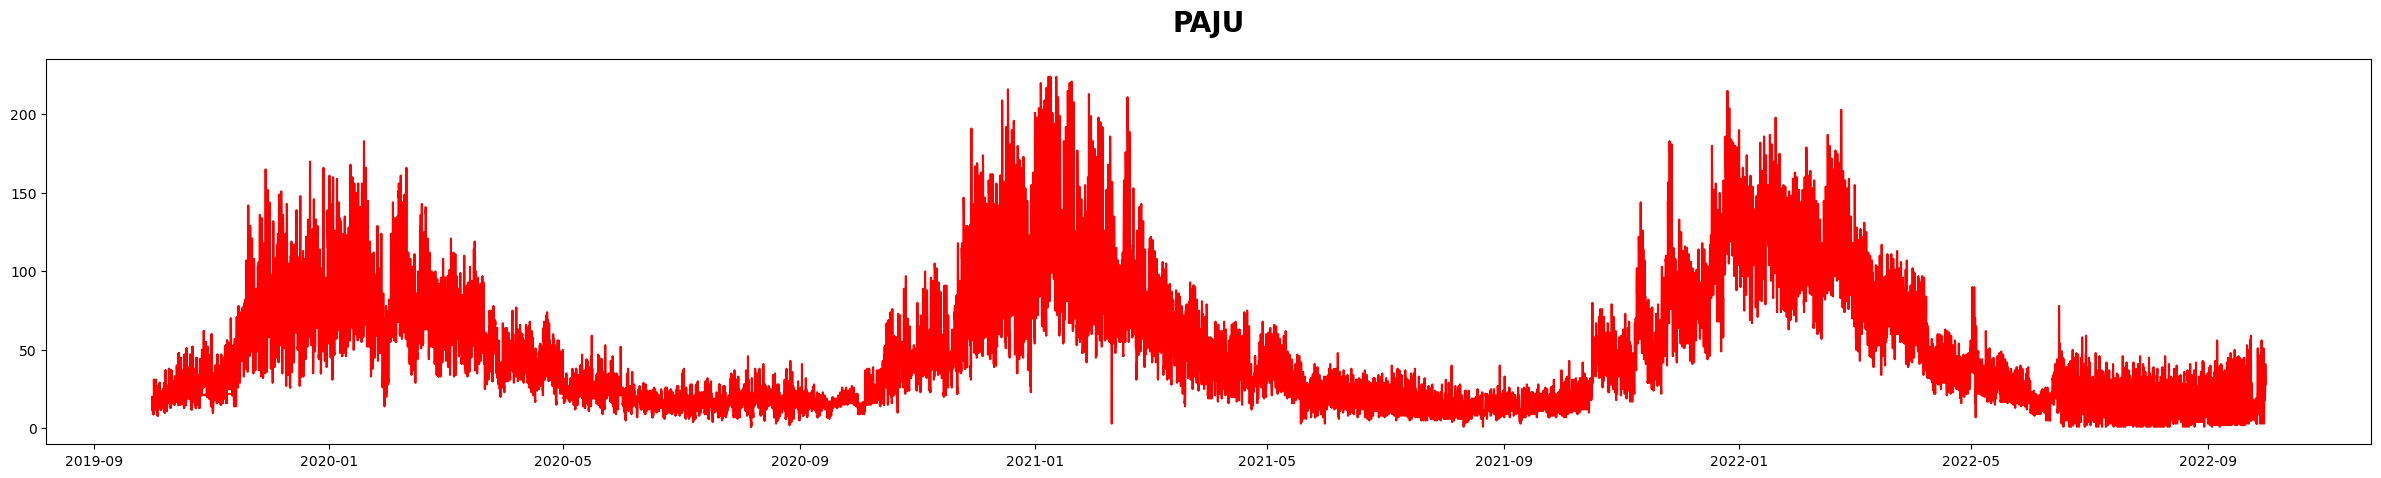

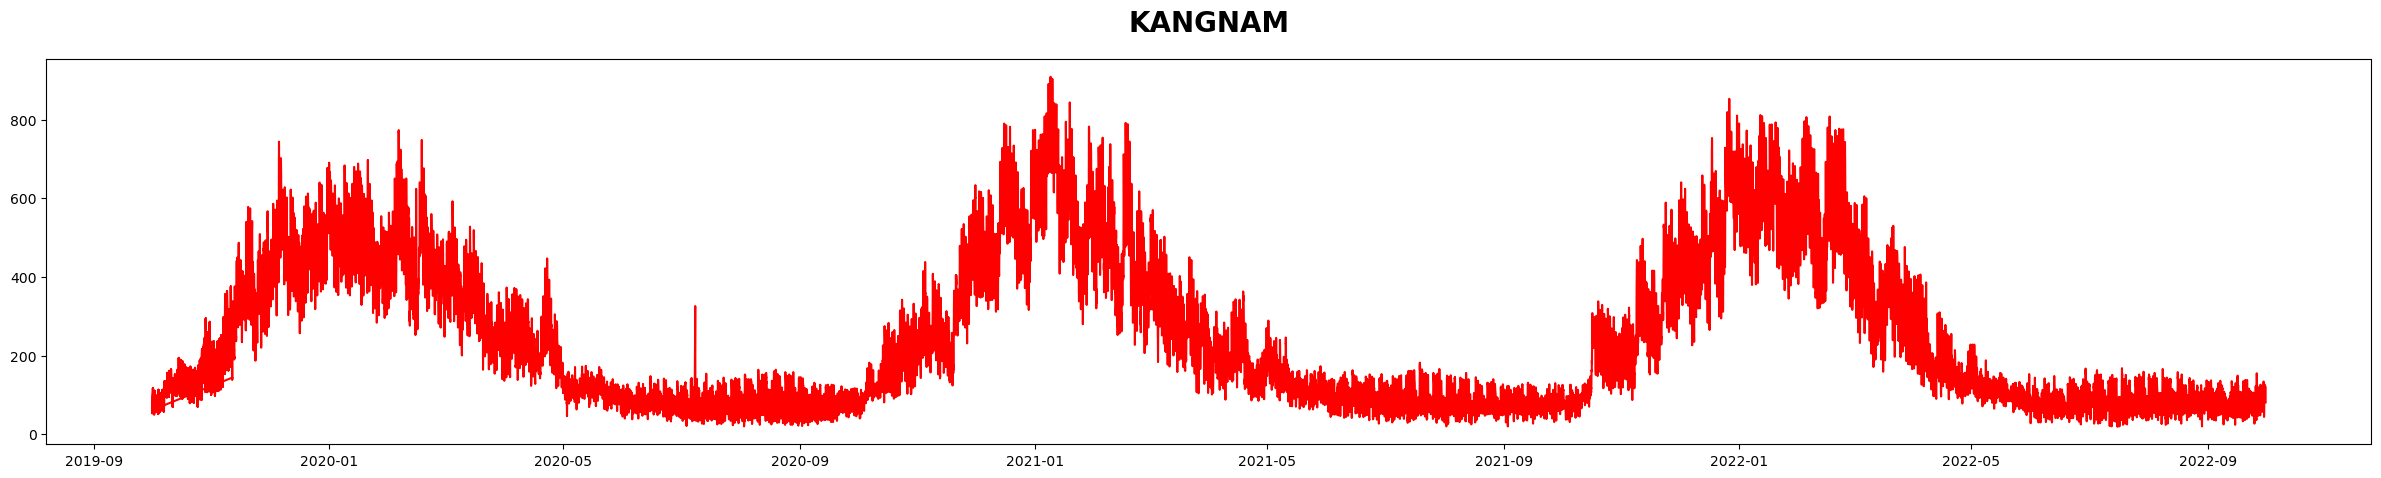

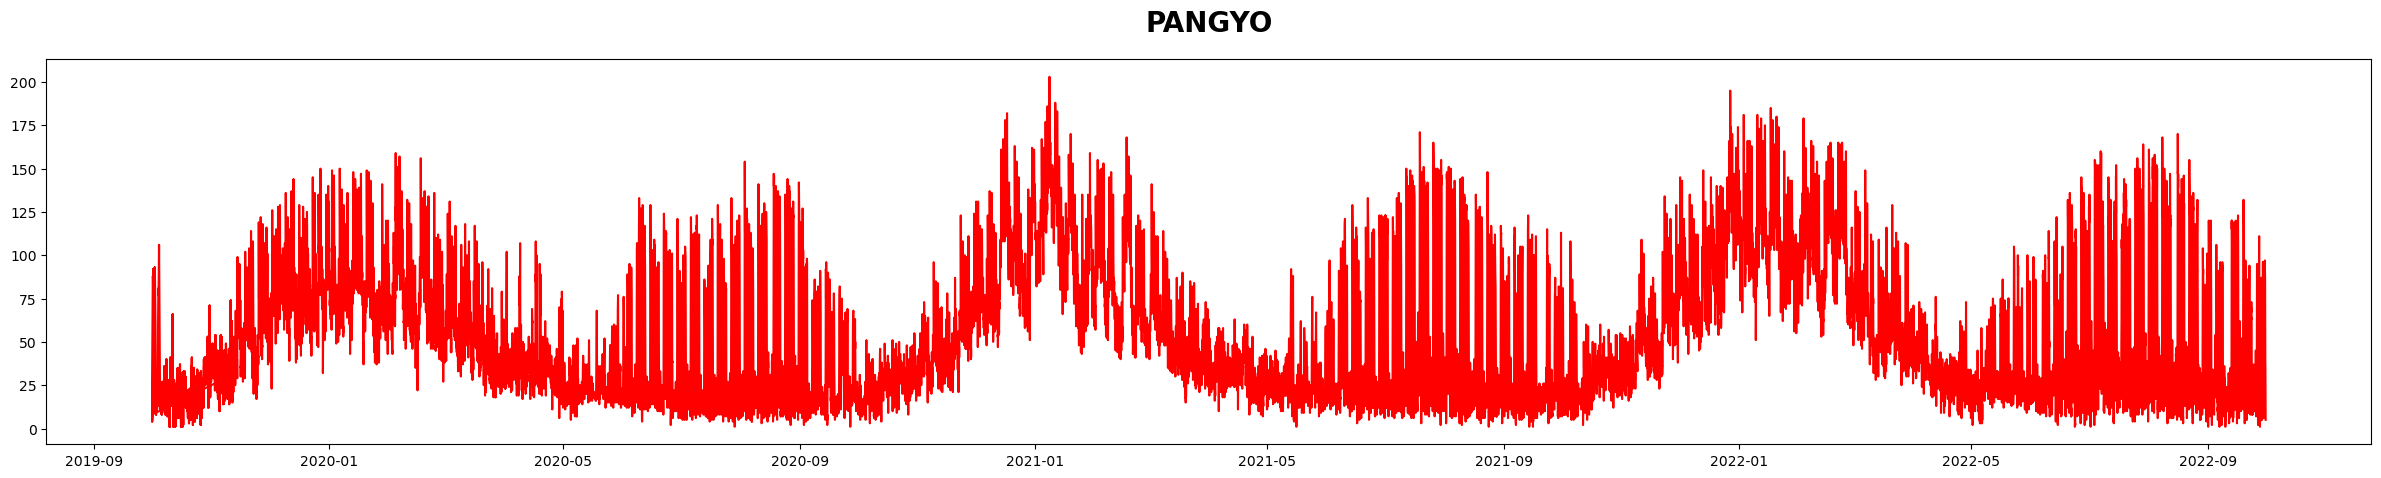

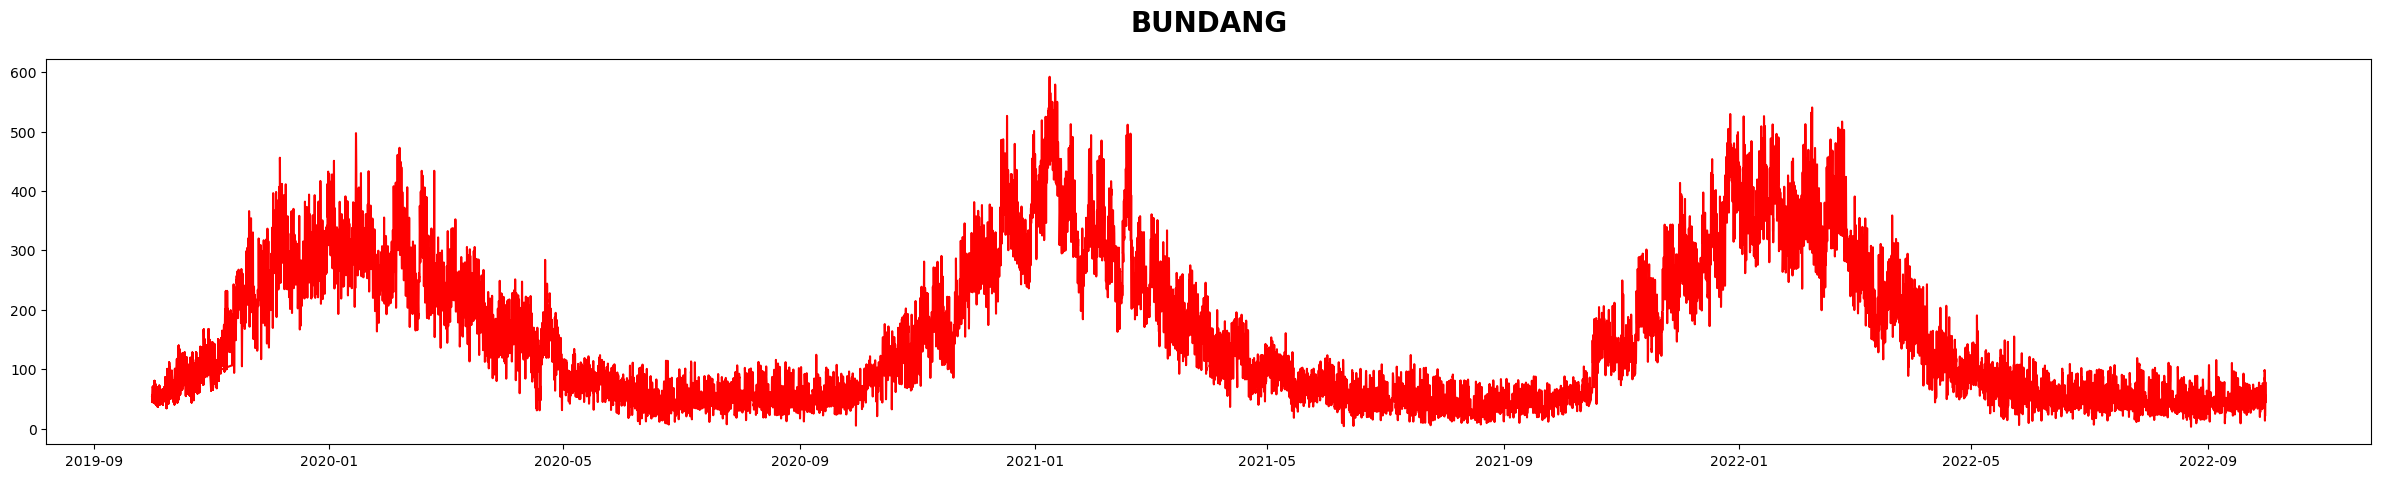

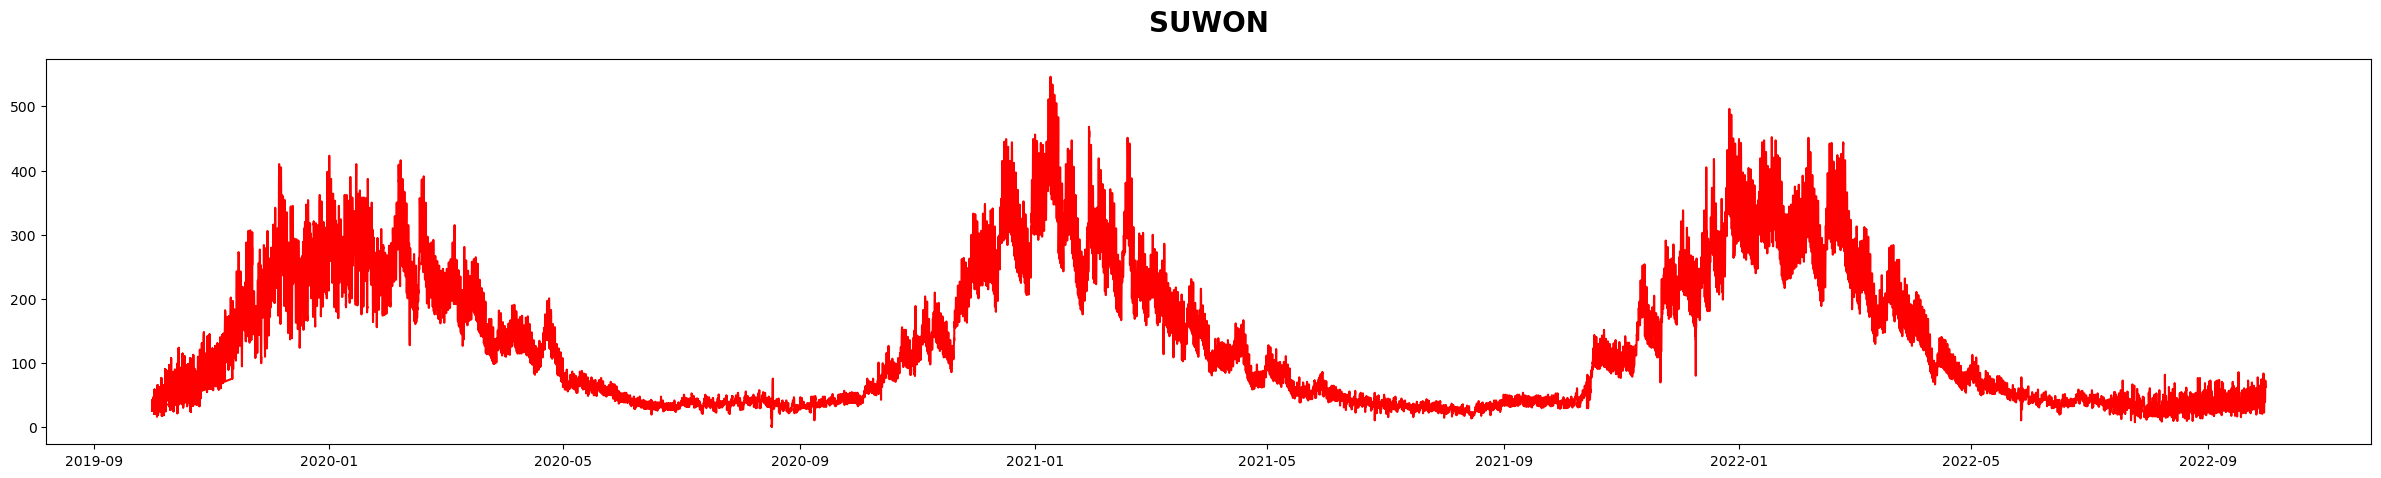

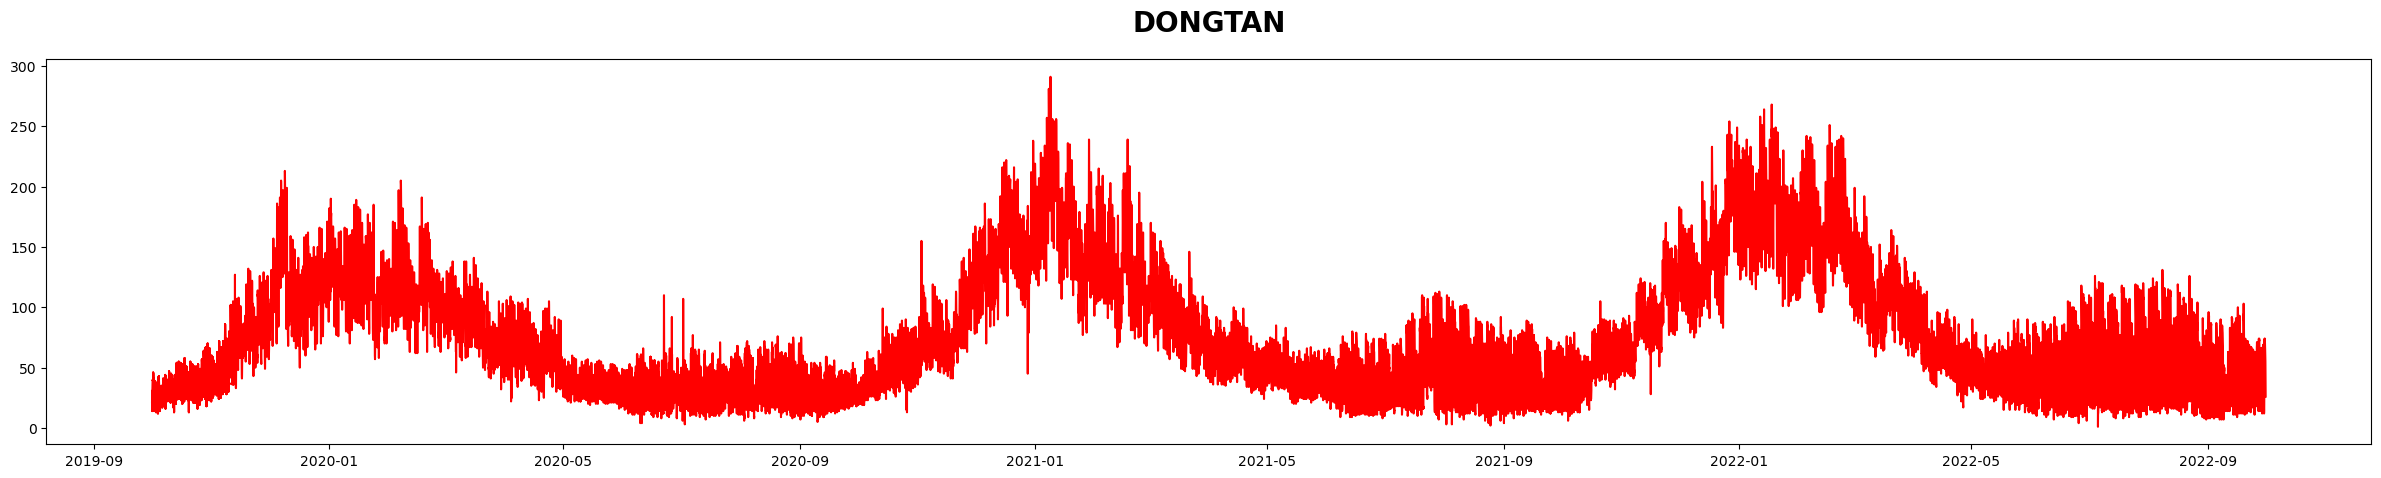

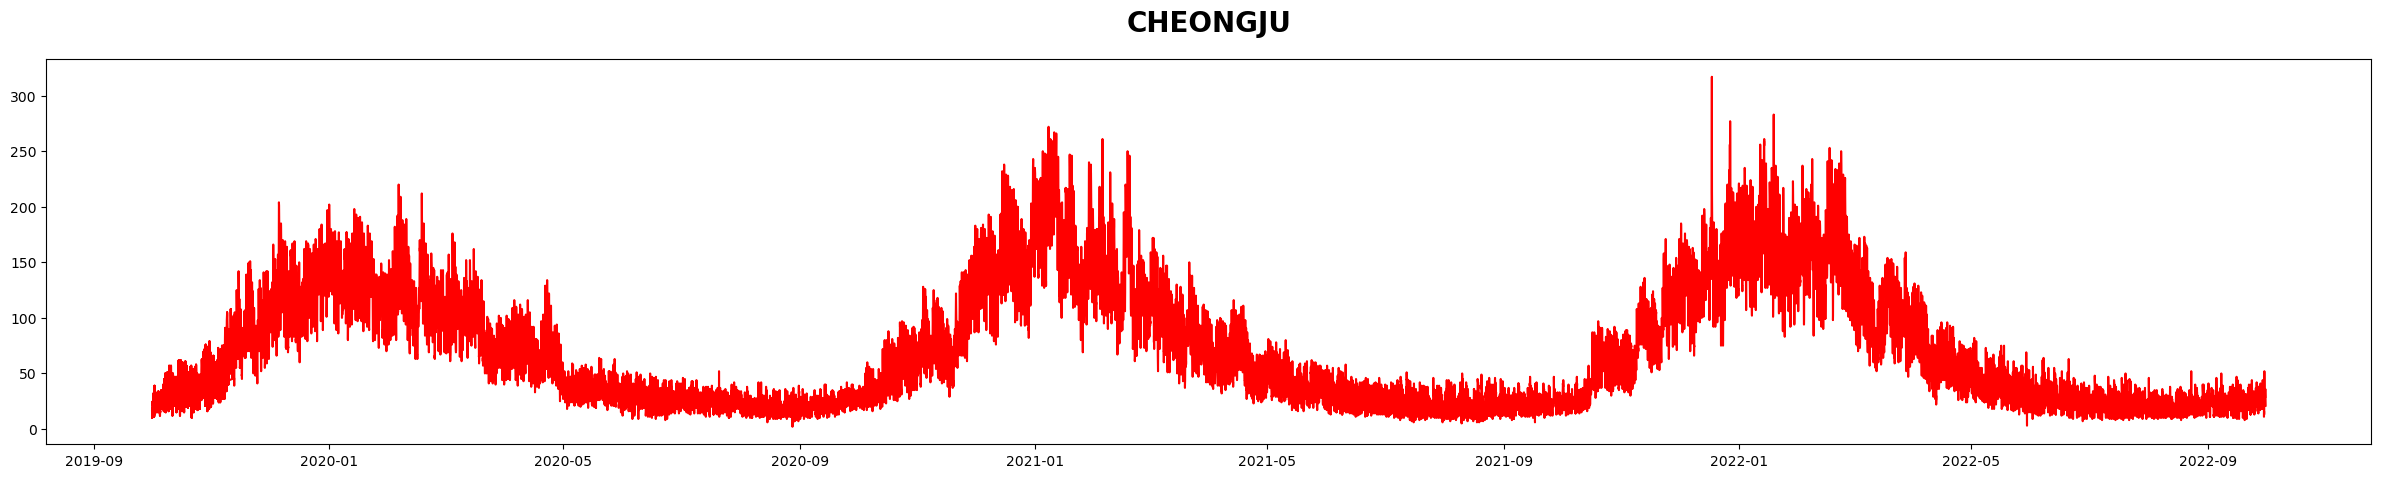

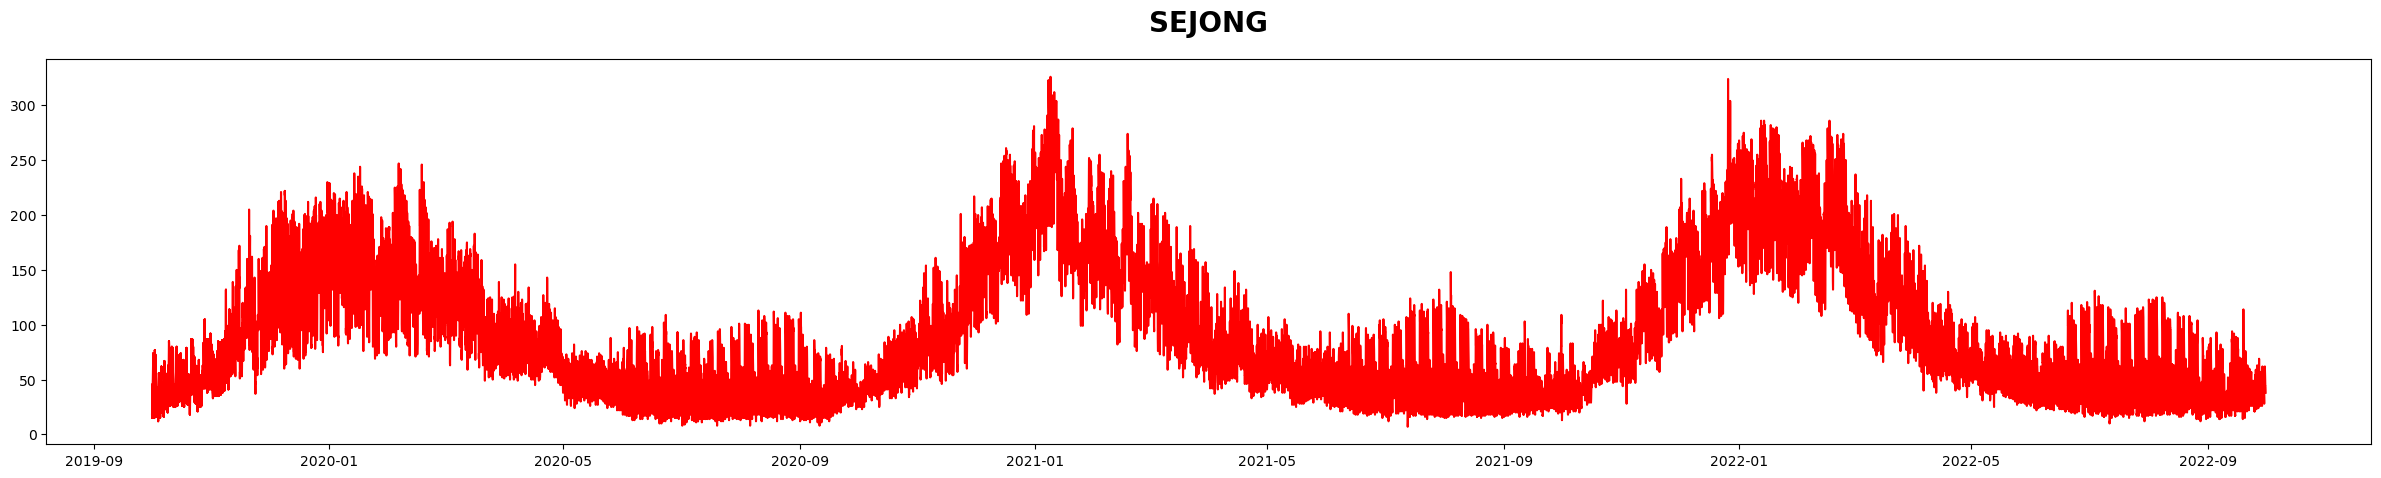

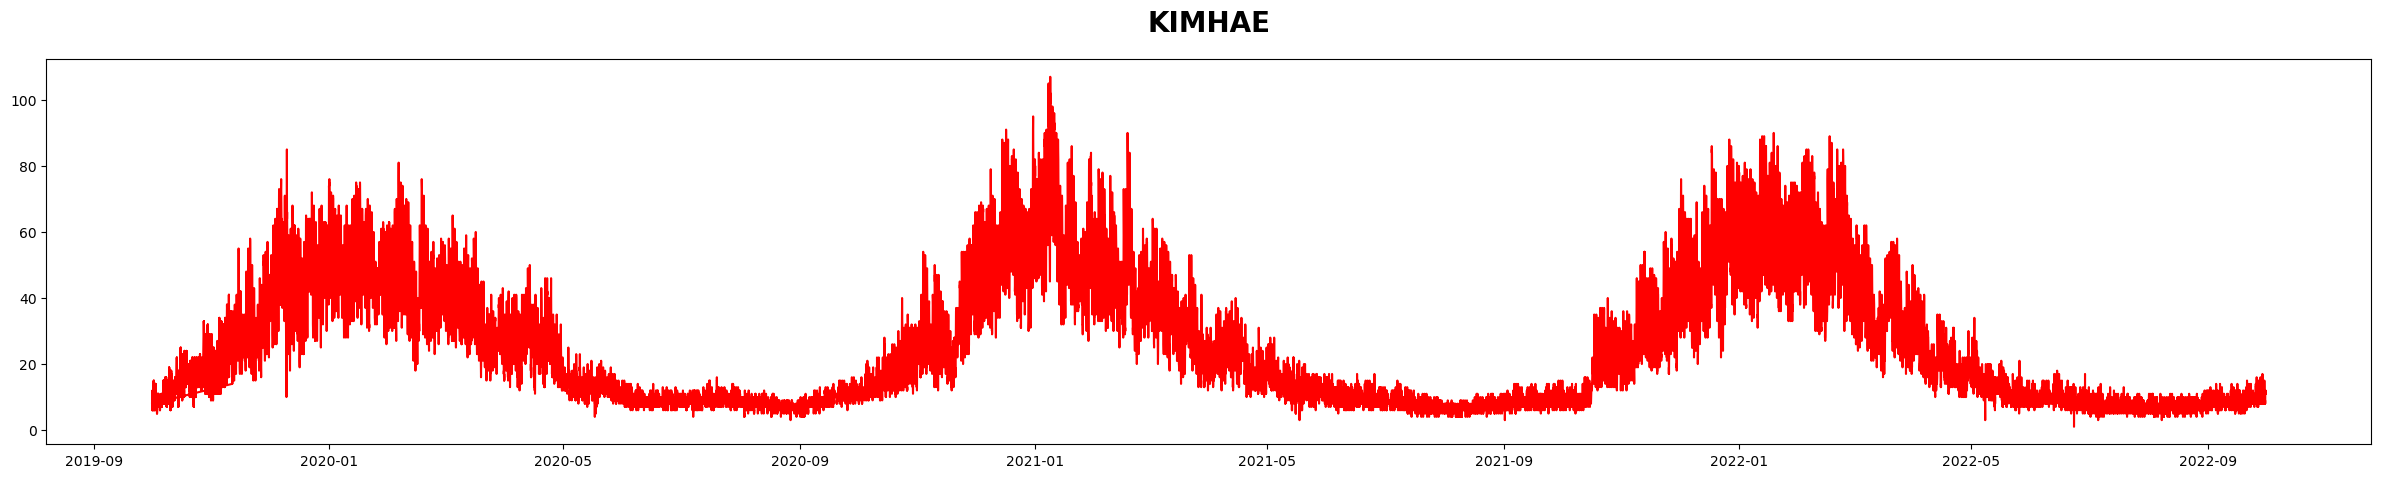

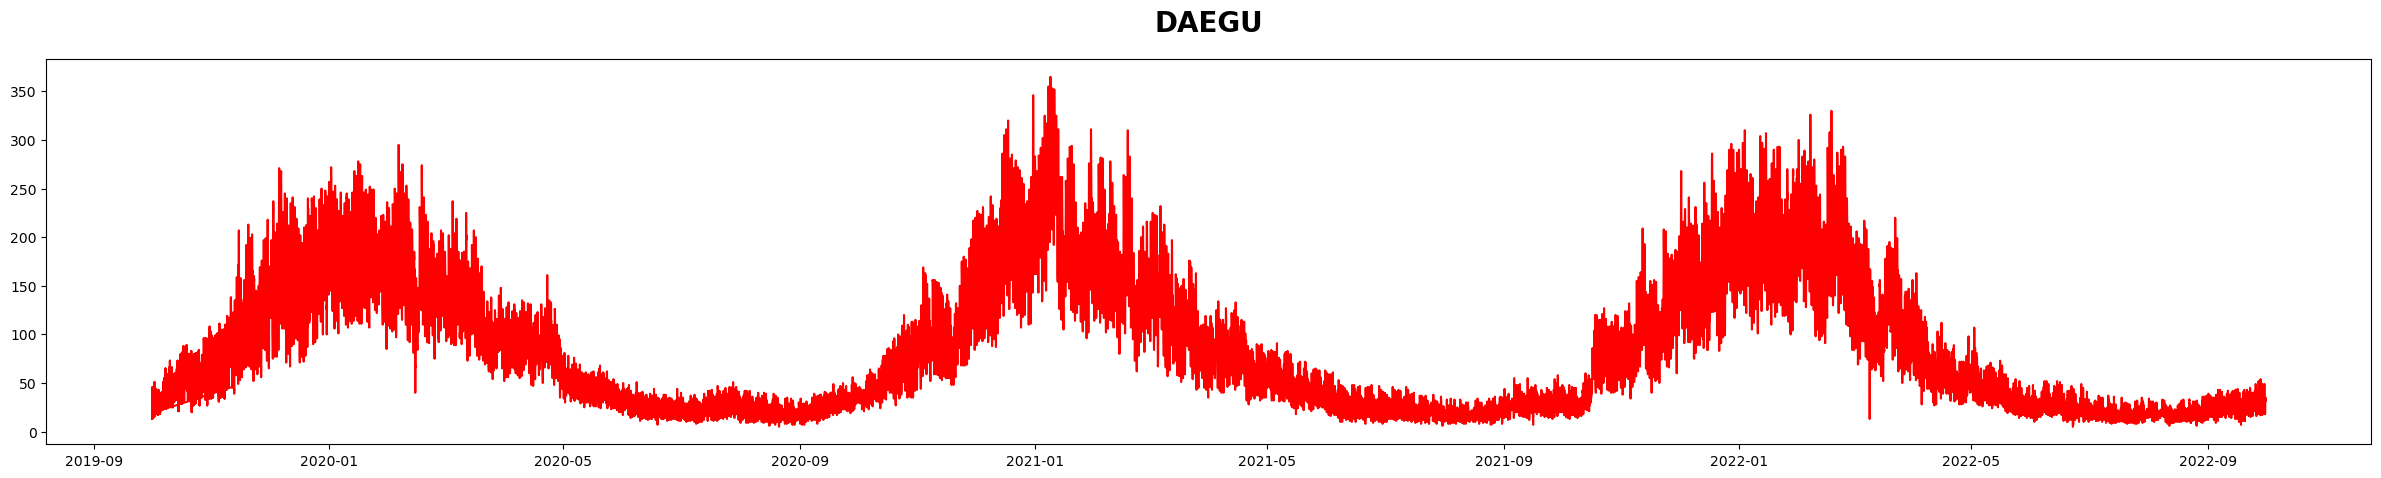

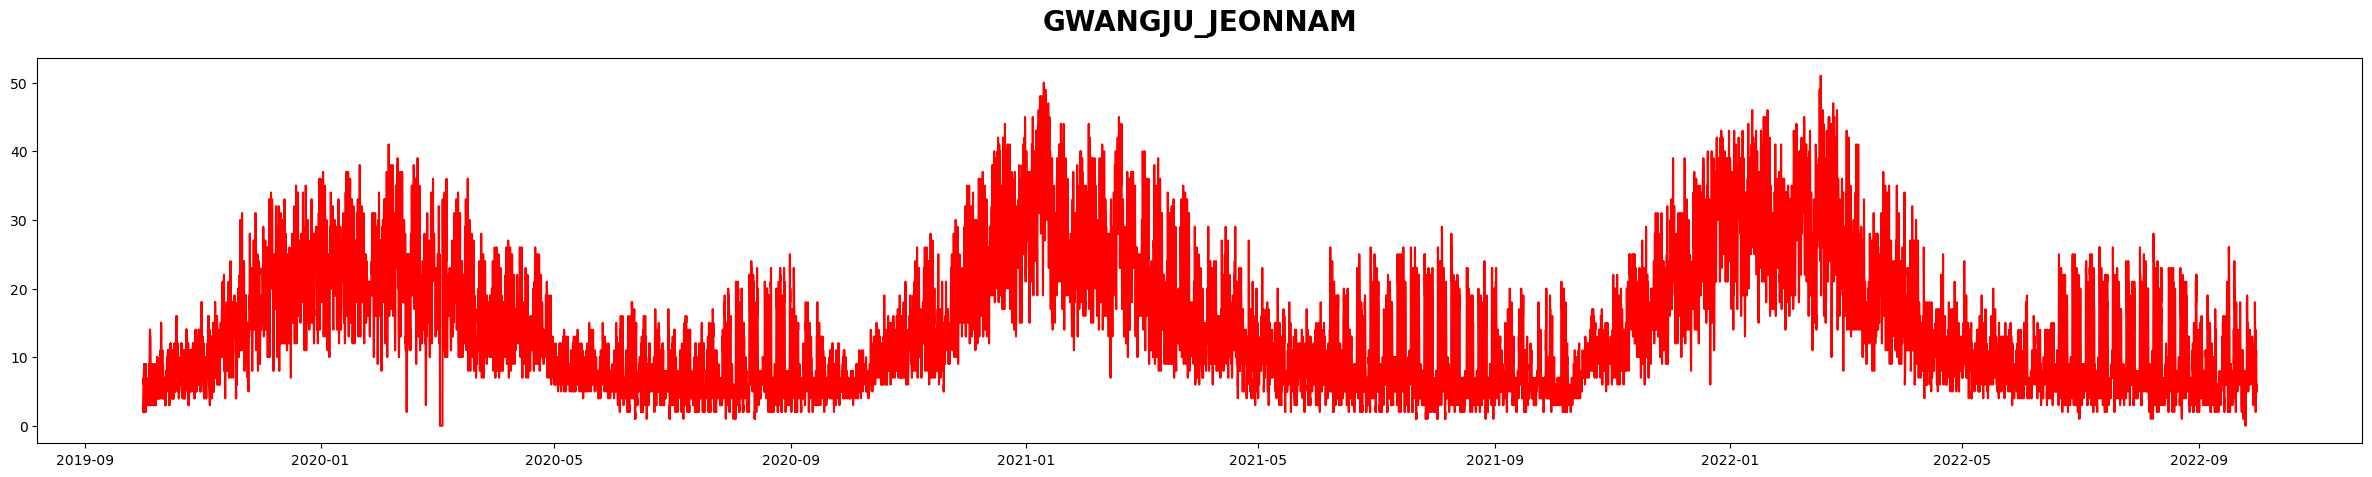

In [9]:
df_kdhc_heat = com_date.create_col_ymdhm(df_kdhc_heat, 'METER_DATE')
df_kdhc_heat = com_date.create_col_weekdays(df_kdhc_heat, 'METER_DATE')

# list_col = np.delete(df_kdhc_heat.columns.values, 0, 0)
list_col = ['PAJU' ## 파주 기상정보
            , 'KANGNAM' ## 서울 기상정보
            , 'PANGYO', 'BUNDANG', 'SUWON', 'DONGTAN' ## 수원 기상정보
            , 'CHEONGJU', 'SEJONG' ## 청주 기상정보
            , 'KIMHAE' ## 김해 기상정보
            , 'DAEGU' ## 대구 기상정보
            , 'GWANGJU_JEONNAM'] ## 전남광주 기상정보

for col in list_col:
    print(col)
    com_Analysis.print_desc_statistic(df_kdhc_heat, col)
    com_Analysis.find_outlier_Usages(df_kdhc_heat, col)
    for i in range(0, 50):
        com_Prep.del_outlier_Usages(df_kdhc_heat, col)

for col in list_col:
    com_Visual.visualization_df(df_kdhc_heat, col, 'red')

### 01-02-02. KMA ASOS (Weather)

In [ ]:
dict_Obs = {'99' : 'PAJU'
            , '108' : 'SEOUL'
            , '119' : 'SUWON'
            , '131' : 'CHEONGJU'
            , '143' : 'DAEGU'
            , '156' : 'GWANGJU_JEONNAM'
            , '253' : 'KIMHAE'}

str_Obs = "119"

# str_year_Start = 2022
# str_year_End = 2023

# Define data root directory
str_dir_kmaAsos = "../data/data_KMA_ASOS/"
str_fileRaw = "KMA_ASOS_" + str_Obs + "_2010_2023_Interpolated.csv"

In [ ]:
df_kma_asos = pd.read_csv(str_dir_kmaAsos + str_fileRaw)
df_kma_asos

,METER_DATE,YEAR,MONTH,DAY,HOUR,MINUTE,temp_outdoor,temp_dew_point,temp_ground,humidity,...,wind_speed,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range
0,2010-01-01 00:00:00,2010,1,1,0,0,-10.3000000000,-17.6000000000,-5.8000000000,55.0000000000,...,1.6000000000,340.0000000000,1.5000000000,1019.7000000000,1024.3000000000,NaN,NaN,0.0000000000,0.0000000000,2000.0000000000
1,2010-01-01 01:00:00,2010,1,1,1,0,-10.4000000000,-17.9000000000,-5.7000000000,54.0000000000,...,0.3000000000,0.0000000000,1.5000000000,1019.5000000000,1024.1000000000,NaN,NaN,NaN,NaN,NaN
2,2010-01-01 02:00:00,2010,1,1,2,0,-10.6000000000,-17.6000000000,-5.9000000000,56.0000000000,...,0.6000000000,270.0000000000,1.5000000000,1019.7000000000,1024.3000000000,NaN,NaN,NaN,NaN,NaN
3,2010-01-01 03:00:00,2010,1,1,3,0,-11.0000000000,-18.0000000000,-5.9000000000,56.0000000000,...,1.5000000000,290.0000000000,1.5000000000,1019.7000000000,1024.3000000000,NaN,NaN,0.0000000000,0.0000000000,2000.0000000000
4,2010-01-01 04:00:00,2010,1,1,4,0,-11.6000000000,-18.2000000000,-6.0000000000,58.0000000000,...,0.9000000000,290.0000000000,1.5000000000,1019.4000000000,1024.0000000000,NaN,NaN,0.0000000000,0.0000000000,2000.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116911,2023-10-17 19:00:00,2023,10,17,19,0,14.4000000000,4.9000000000,14.7000000000,53.0000000000,...,0.4000000000,0.0000000000,8.7000000000,1015.1000000000,1019.9000000000,NaN,NaN,0.0000000000,0.0000000000,5000.0000000000
116912,2023-10-17 20:00:00,2023,10,17,20,0,12.5000000000,5.8000000000,13.4000000000,64.0000000000,...,0.3000000000,0.0000000000,9.2000000000,1015.6000000000,1020.4000000000,NaN,NaN,0.0000000000,0.0000000000,3742.0000000000
116913,2023-10-17 21:00:00,2023,10,17,21,0,11.4000000000,6.5000000000,12.4000000000,72.0000000000,...,0.8000000000,320.0000000000,9.7000000000,1015.8000000000,1020.6000000000,NaN,NaN,0.0000000000,0.0000000000,3158.0000000000
116914,2023-10-17 22:00:00,2023,10,17,22,0,10.2000000000,6.8000000000,11.5000000000,80.0000000000,...,0.8000000000,320.0000000000,9.9000000000,1016.2000000000,1021.1000000000,NaN,NaN,0.0000000000,0.0000000000,3321.0000000000


### 01-02-03. KASI DATE

In [ ]:
str_dir_kmaAsos = "./data_Date_KASI/"
str_fileRaw = "KASI_DATE_H_Final.csv"

In [ ]:
df_kasiDate = pd.read_csv(str_dir_kmaAsos + str_fileRaw)
df_kasiDate = df_kasiDate.reset_index()
df_kasiDate['METER_DATE'] = pd.to_datetime(df_kasiDate['locdate'])
df_kasiDate = df_kasiDate[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'day_of_the_week'
                            , 'rest_YN', 'dist_from_holiday'
                            , 'HOUR', 'MINUTE']]
print(df_kasiDate.columns)
df_kasiDate

Index(['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week',
       'day_of_the_week', 'rest_YN', 'dist_from_holiday', 'HOUR', 'MINUTE'],
      dtype='object')


,METER_DATE,YEAR,MONTH,DAY,code_day_of_the_week,day_of_the_week,rest_YN,dist_from_holiday,HOUR,MINUTE
0,2010-01-01 00:00:00,2010,1,1,4,Friday,1,0,0,0
1,2010-01-01 01:00:00,2010,1,1,4,Friday,1,0,1,0
2,2010-01-01 02:00:00,2010,1,1,4,Friday,1,0,2,0
3,2010-01-01 03:00:00,2010,1,1,4,Friday,1,0,3,0
4,2010-01-01 04:00:00,2010,1,1,4,Friday,1,0,4,0
...,...,...,...,...,...,...,...,...,...,...
122708,2023-12-30 20:00:00,2023,12,30,5,Saturday,1,0,20,0
122709,2023-12-30 21:00:00,2023,12,30,5,Saturday,1,0,21,0
122710,2023-12-30 22:00:00,2023,12,30,5,Saturday,1,0,22,0
122711,2023-12-30 23:00:00,2023,12,30,5,Saturday,1,0,23,0


### 01-03. Combine

In [ ]:
df_merge = pd.DataFrame()

df_kdhc_heat['METER_DATE'] = pd.to_datetime(df_kdhc_heat['METER_DATE'])
df_kma_asos['METER_DATE'] = pd.to_datetime(df_kma_asos['METER_DATE'])
df_kasiDate['METER_DATE'] = pd.to_datetime(df_kasiDate['METER_DATE'])

date_khdc = pd.to_datetime(df_kdhc_heat['METER_DATE'])
date_kma = pd.to_datetime(df_kma_asos['METER_DATE'])
date_kasi = pd.to_datetime(df_kasiDate['METER_DATE'])

str_date_start = date_khdc.min()
if str_date_start < date_kma.min():
    str_date_start = date_kma.min()
if str_date_start < date_kasi.min():
    str_date_start = date_kasi.min()
print(str_date_start)

str_date_end = date_khdc.max()
if str_date_end > date_kma.max():
    str_date_end = date_kma.max()
if str_date_end > date_kasi.max():
    str_date_end = date_kasi.max()
print(str_date_end)

df_merge = pd.DataFrame()
df_merge = com_date.create_df_dt(df_merge, "METER_DATE", str_date_start, str_date_end, "1H")
df_merge

2019-10-01 01:00:00
2022-10-01 00:00:00


,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week
0,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1
1,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1
2,2019-10-01 03:00:00,Tuesday,2019,10,1,3,0,1
3,2019-10-01 04:00:00,Tuesday,2019,10,1,4,0,1
4,2019-10-01 05:00:00,Tuesday,2019,10,1,5,0,1
...,...,...,...,...,...,...,...,...
26299,2022-09-30 20:00:00,Friday,2022,9,30,20,0,4
26300,2022-09-30 21:00:00,Friday,2022,9,30,21,0,4
26301,2022-09-30 22:00:00,Friday,2022,9,30,22,0,4
26302,2022-09-30 23:00:00,Friday,2022,9,30,23,0,4


In [ ]:
print(df_merge.columns)
print(df_kasiDate.columns)
print(df_kma_asos.columns)
print(df_kdhc_heat.columns)

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week'],
      dtype='object')
Index(['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week',
       'day_of_the_week', 'rest_YN', 'dist_from_holiday', 'HOUR', 'MINUTE'],
      dtype='object')
Index(['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'temp_outdoor',
       'temp_dew_point', 'temp_ground', 'humidity', 'rainfall', 'snowfall',
       'snowfall_3hr', 'wind_speed', 'wind_direction', 'pressure_vapor',
       'pressure_area', 'pressure_sea', 'sunshine', 'solar_radiation',
       'cloud_total', 'cloud_midlow', 'visual_range'],
      dtype='object')
Index(['METER_DATE', 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM',
       'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG',
       'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU',
       'YANGSAN', 'GWANGJU_JEONNAM', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE',
       'day_of_the_week', 

In [ ]:
df_merge = pd.merge(df_merge, df_kasiDate
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'day_of_the_week'
                                          , 'HOUR', 'MINUTE'])
df_merge = pd.merge(df_merge, df_kma_asos
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE'])
df_merge = pd.merge(df_merge, df_kdhc_heat
                    , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'day_of_the_week'
                                          , 'HOUR', 'MINUTE'])
print(df_merge.shape)
print(df_merge.columns)

(27303, 46)
Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM', 'PANGYO', 'BUNDANG',
       'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK',
       'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU', 'YANGSAN', 'GWANGJU_JEONNAM'],
      dtype='object')


In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27303 entries, 0 to 27302
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   METER_DATE            27303 non-null  datetime64[ns]
 1   day_of_the_week       27303 non-null  object        
 2   YEAR                  27303 non-null  int64         
 3   MONTH                 27303 non-null  int64         
 4   DAY                   27303 non-null  int64         
 5   HOUR                  27303 non-null  int64         
 6   MINUTE                27303 non-null  int64         
 7   code_day_of_the_week  27303 non-null  int64         
 8   rest_YN               27303 non-null  object        
 9   dist_from_holiday     27303 non-null  object        
 10  temp_outdoor          27300 non-null  float64       
 11  temp_dew_point        27298 non-null  float64       
 12  temp_ground           27251 non-null  float64       
 13  humidity        

In [ ]:
df_merge['temp_outdoor'] = df_merge['temp_outdoor'].interpolate()
df_merge['temp_dew_point'] = df_merge['temp_dew_point'].interpolate()
df_merge['temp_ground'] = df_merge['temp_ground'].interpolate()
df_merge['humidity'] = df_merge['humidity'].interpolate()

df_merge['rainfall'] = df_merge['rainfall'].fillna(0)
df_merge['snowfall'] = df_merge['snowfall'].fillna(0)
df_merge['snowfall_3hr'] = df_merge['snowfall_3hr'].fillna(0)

df_merge['wind_speed'] = df_merge['wind_speed'].interpolate()
df_merge['wind_direction'] = df_merge['wind_direction'].interpolate()
df_merge['pressure_vapor'] = df_merge['pressure_vapor'].interpolate()
df_merge['pressure_area'] = df_merge['pressure_area'].interpolate()
df_merge['pressure_sea'] = df_merge['pressure_sea'].interpolate()

df_merge['sunshine'] = df_merge['sunshine'].fillna(0)
df_merge['solar_radiation'] = df_merge['solar_radiation'].fillna(0)

df_merge['cloud_total'] = df_merge['cloud_total'].interpolate()
df_merge['cloud_midlow'] = df_merge['cloud_midlow'].interpolate()
df_merge['visual_range'] = df_merge['visual_range'].interpolate()

In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27303 entries, 0 to 27302
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   METER_DATE            27303 non-null  datetime64[ns]
 1   day_of_the_week       27303 non-null  object        
 2   YEAR                  27303 non-null  int64         
 3   MONTH                 27303 non-null  int64         
 4   DAY                   27303 non-null  int64         
 5   HOUR                  27303 non-null  int64         
 6   MINUTE                27303 non-null  int64         
 7   code_day_of_the_week  27303 non-null  int64         
 8   rest_YN               27303 non-null  object        
 9   dist_from_holiday     27303 non-null  object        
 10  temp_outdoor          27303 non-null  float64       
 11  temp_dew_point        27303 non-null  float64       
 12  temp_ground           27303 non-null  float64       
 13  humidity        

In [ ]:
str_file = "KDHC_COMB_HEATxWEATHER_2019-2022.csv"

print(df_merge.info())
df_merge.to_csv(str_dir_kdhcHeat + str_file)
df_merge

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,rest_YN,dist_from_holiday,...,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
1,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
3,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019-10-01 03:00:00,Tuesday,2019,10,1,3,0,1,0,2,...,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,Friday,2022,9,30,20,0,4,0,1,...,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022-09-30 21:00:00,Friday,2022,9,30,21,0,4,0,1,...,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022-09-30 22:00:00,Friday,2022,9,30,22,0,4,0,1,...,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
27301,2022-09-30 23:00:00,Friday,2022,9,30,23,0,4,0,1,...,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6


In [ ]:
df_merge = df_merge[['METER_DATE'
                     , 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
                     , 'KANGNAM'
                     , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
                     , 'KIMHAE', 'DAEGU', 'YANGSAN'
                     , 'GWANGJU_JEONNAM']]

str_file = "KDHC_COMB_HEAT_2019-2022.csv"

print(df_merge.info())
df_merge.to_csv(str_dir_kdhcHeat + str_file)
df_merge

,METER_DATE,PAJU,GOYANG,SAMSONG,JOONGANG,KANGNAM,PANGYO,BUNDANG,YONGIN,GWANGGYO,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,20,73.0000000000,8.0000000000,20.0000000000,61.3000000000,8.0000000000,55.1000000000,30.0000000000,14.0000000000,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
1,2019-10-01 01:00:00,20,73.0000000000,8.0000000000,20.0000000000,61.3000000000,8.0000000000,55.1000000000,30.0000000000,14.0000000000,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019-10-01 02:00:00,15,65.0000000000,12.0000000000,18.0000000000,61.3000000000,4.0000000000,56.0000000000,25.0000000000,7.0000000000,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
3,2019-10-01 02:00:00,15,65.0000000000,12.0000000000,18.0000000000,61.3000000000,4.0000000000,56.0000000000,25.0000000000,7.0000000000,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019-10-01 03:00:00,14,58.0000000000,12.0000000000,17.0000000000,56.3000000000,5.0000000000,51.0000000000,18.0000000000,11.0000000000,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,41,81.0000000000,44.0000000000,45.0000000000,120.0000000000,37.0000000000,74.4000000000,87.0000000000,40.0000000000,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022-09-30 21:00:00,40,90.0000000000,46.0000000000,46.0000000000,112.0000000000,36.0000000000,78.4000000000,91.0000000000,25.0000000000,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022-09-30 22:00:00,37,95.0000000000,39.0000000000,44.0000000000,95.0000000000,24.0000000000,65.4000000000,81.0000000000,16.0000000000,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
27301,2022-09-30 23:00:00,32,98.0000000000,35.0000000000,41.0000000000,89.0000000000,19.0000000000,51.4000000000,80.0000000000,16.0000000000,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6
